# 1. Importing Python Libraries

### In the first step, we will import all the necessary python libraries to be required in visualization, data cleaning, machine learning model building and evaluation process.

In [1]:
# load all necessary libraries
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# libraries for nlp task
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# machine learning
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold

# filtering warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Read Dataset

### After importing all the libraries we have to load the dataset by using pandas library and pandas.read_csv() method.

In [2]:
# load data
df = pd.read_csv('D:/Data Science Final Project 2_Sentiment Analysis/financial_sentiment_data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based S...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real possibility",negative
2,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the sa...",positive
3,"According to the Finnish-Russian Chamber of Commerce , all the major construction companies of F...",neutral
4,"The Swedish buyout firm has sold its remaining 22.4 percent stake , almost eighteen months after...",neutral


### After reading the data and checking sample records, we have to check the shape of the dataset by executing df.info() command in pandas.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


### As we can see from the above information that dataset has 5842 records having non-null entries.

# 3. Exploratory Data Analysis (EDA)

In [4]:
df["Sentiment"].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

<AxesSubplot:title={'center':'Counts of every Sentiments'}>

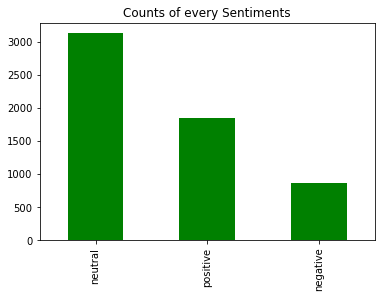

In [5]:
df["Sentiment"].value_counts().plot(kind = "bar", color = "g",title="Counts of every Sentiments")

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

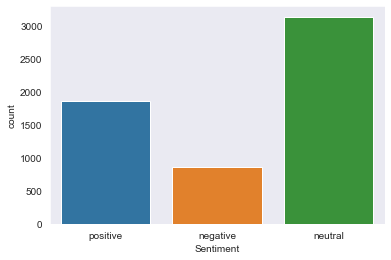

In [6]:
sns.set_style("dark")
sns.countplot(df.Sentiment)

### From the dataset, it is visible that the dataset is highly imbalanced having majority of records with neutral sentiments whereas positive and negative sentiments have lower number of records in the dataset.

### So, next we have to balance the dataset and we will do it by down sampling the neutral sentiment and positive sentiment records to the level of negative sentiment records i.e., 1000 so that dataset become balanced and the model will give good performance.

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

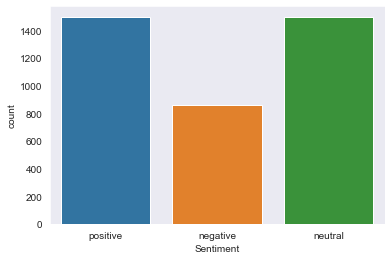

In [7]:
# taking subset of dataset by downsampling records to 2000
df_pos = df[df.Sentiment=='positive'].head(1500)
df_neu = df[df.Sentiment=='neutral'].head(1500)
df_neg = df[df.Sentiment=='negative'].head(1500)

# concatenating the datasets
df_final = pd.concat([df_pos,df_neg],axis=0)
df_final = pd.concat([df_final,df_neu],axis=0)

# checking distribution of target variable in final data
sns.set_style("dark")
sns.countplot(df_final.Sentiment)

## As we can see now we have a balanced distribution of all the classes in the dataset.

### Next we have to shuffle the dataset as we have concatenated different subset of data and it may contain sequence wise patterns. So for shuffling the dataset we will reindex the data frame using Numpy random permutation.

In [8]:
df_final = df_final.reindex(np.random.permutation(df_final.index))
df_final.head(10)

,Sentence,Sentiment
4443,"OUTOTEC OYJ PRESS RELEASE DECEMBER 4 , 2009 10.30 AM Outotec establishes a new subsidiary in Kol...",positive
2513,"Salcomp Oyj , the Finnish maker of mobile phone chargers , Monday posted a EUR1 .49 million loss...",neutral
4094,services supplier Efore Plc to streamline operations in Finland and the US Finnish electronic sy...,positive
1381,Marketing will use Tikkurila 's existing infra structure and local knowledge in Russia .,neutral
143,Aspo has also investigated the sales opportunities of Kaukomarkkinat 's electronics business .,neutral
1766,"Mr. McDonald started the evening with his own set , featuring hits from his solo career and his ...",neutral
102,The decision means temporary lay-offs of fixed duration at the company 's Nastola and Jyvaskyla ...,neutral
826,"Operating profit margin was 8.3 % , compared to 11.8 % a year earlier .",negative
1291,"$TSLA Recalls 2,700 Model X Vehicles; Shares Volatile https://t.co/tcKqZnMIqX #TSLA #tech #stock...",negative
1387,NetCom expects to complete Turbo 3G deployment in these areas this year .,neutral


### After shuffling the dataset, we will calculate the length of the text so that we can do univariate analysis based on different sentiments.

In [9]:
df_final['length'] = df['Sentence'].apply(len)
df_final.head()

,Sentence,Sentiment,length
4443,"OUTOTEC OYJ PRESS RELEASE DECEMBER 4 , 2009 10.30 AM Outotec establishes a new subsidiary in Kol...",positive,252
2513,"Salcomp Oyj , the Finnish maker of mobile phone chargers , Monday posted a EUR1 .49 million loss...",neutral,193
4094,services supplier Efore Plc to streamline operations in Finland and the US Finnish electronic sy...,positive,290
1381,Marketing will use Tikkurila 's existing infra structure and local knowledge in Russia .,neutral,88
143,Aspo has also investigated the sales opportunities of Kaukomarkkinat 's electronics business .,neutral,94


### Next we will check the overall the distribution of length of the texts in the dataset.


In [10]:
df_final.length.describe()

count    3860.000000
mean      115.226943
std        55.854138
min         9.000000
25%        71.000000
50%       104.000000
75%       148.000000
max       305.000000
Name: length, dtype: float64

### As we can see that the highest length of the message in the dataset is 305 whereas minimum length is 10. the average length of the messages in the dataset is 113.

## Now let’s plot the histogram for the length of all the sentiments data.

array([[<AxesSubplot:title={'center':'negative'}>,
        <AxesSubplot:title={'center':'neutral'}>],
       [<AxesSubplot:title={'center':'positive'}>, <AxesSubplot:>]],
      dtype=object)

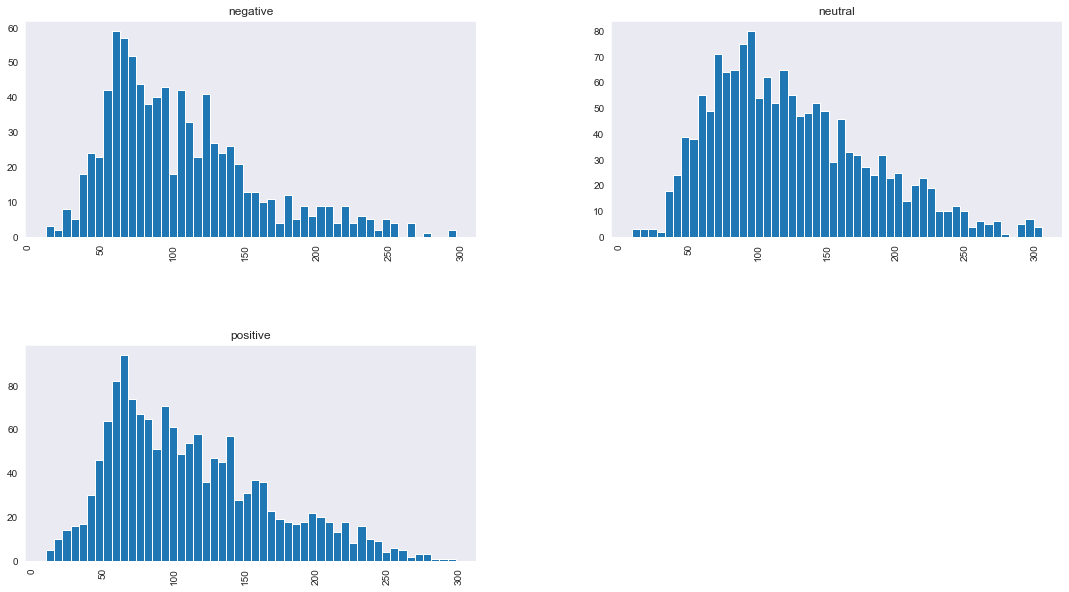

In [11]:
#Histogram

df_final.hist(column='length', by='Sentiment', bins=50,figsize=(18,10))

## From the above distribution, we can observe that Neutal Sentiment messages are usually longer in length as they have dense distribution from length 50 to 200 whereas majority of shorter messages of length <=10 (length less than 10) belongs to negative sentiment.

# 4. Word cloud

### Next, we will plot the word cloud so that we can understand the class-wise distribution of words in the dataset. But before plotting word cloud we need to remove stop words so that it can only show significant words in the word cloud.

Text(0.5, 1.0, 'Neutral Sentiment')

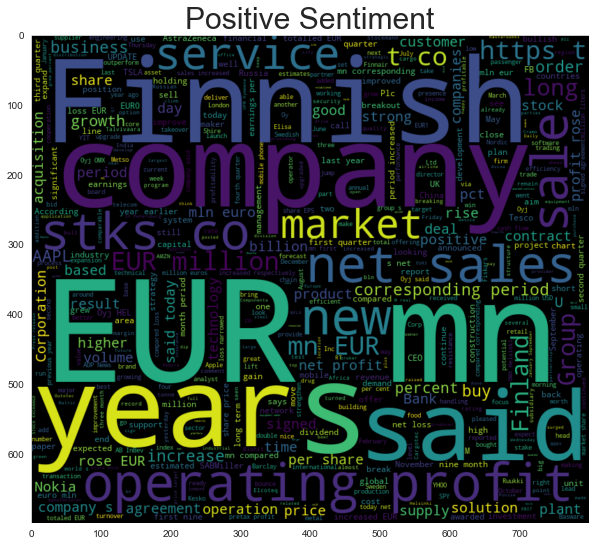

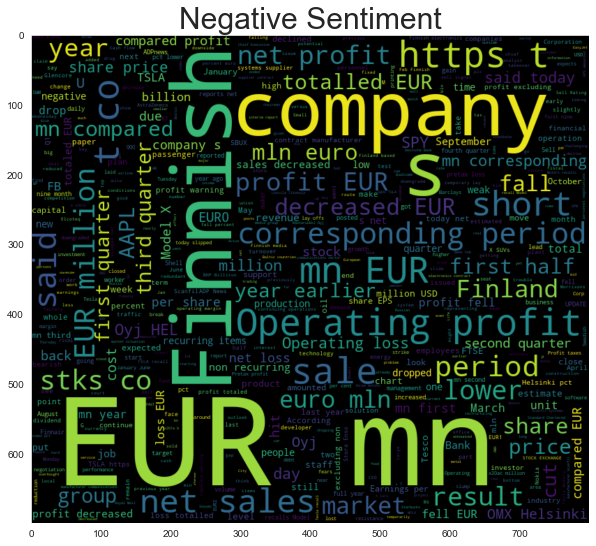

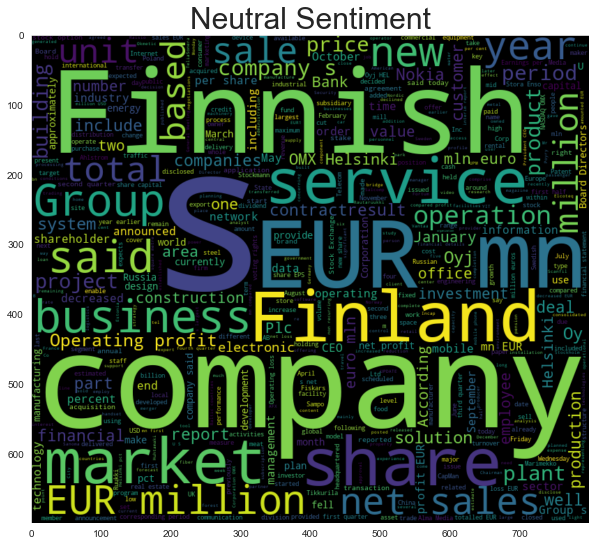

In [12]:
# creating list of stop words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
# Removing stop words which are unneccesary from financial text text
def remove_stopwords(Sentence):
    final_Sentence = []
    for i in Sentence.split():
        if i.strip().lower() not in stop:
            final_Sentence.append(i.strip())
    return " ".join(final_Sentence)
df_pos['Sentence']=df_pos['Sentence'].apply(remove_stopwords)
df_neg['Sentence']=df_neg['Sentence'].apply(remove_stopwords)
df_neu['Sentence']=df_neu['Sentence'].apply(remove_stopwords)


# plotting Positive sentiment wordcloud
plt.figure(figsize = (10,12)) # Sentence that is Positive sentiment
wc = WordCloud(max_words = 500 , width = 800 , height = 700).generate(" ".join(df_pos.Sentence))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Positive Sentiment',fontsize= 30)


# plotting Negative sentiment wordcoud
plt.figure(figsize = (10,12)) # Sentence that is Positive sentiment
wc = WordCloud(max_words = 500 , width = 800 , height = 700).generate(" ".join(df_neg.Sentence))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Negative Sentiment',fontsize= 30)


# plotting Neutral sentiment wordcoud
plt.figure(figsize = (10,12)) # Sentence that is Positive sentiment
wc = WordCloud(max_words = 500 , width = 800 , height = 700).generate(" ".join(df_neu.Sentence))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Neutral Sentiment',fontsize= 30)

 

### As we can see from above word cloud, positive sentiment consists of high frequency words such as operating Finnish, EUR , Year, Company, mn, new, said etc.,

### whereas negative sentiment consists of words such as Million, Comapny, operating, profit, net, sales, EUR, mn, https etc.

### Neutral sentiment consists of words such as Finnish, Company, operation. group, EUR, S, Business, Finland, Share etc

# 5. Data Cleaning and Data preprocessing

### In this step, we will perform following steps

                           1)  lowercase all the words
                           2)  remove the stop words
                           3)  tokenize the text
                           4)  perform lemmatization 
                           5)  remove all non-alphabetic characters from the text
                           
### The code for the above-mentioned task is shared below:

In [13]:
lemma = WordNetLemmatizer()

#creating list of possible stopwords from nltk library
stop = stopwords.words('english')
def cleanSentence(Sentence):
  # lowercaing
    Sentence = Sentence.lower()
    # tokenization
    words = nltk.word_tokenize(Sentence)
  # removing stopwords & mennatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in (stop)])
    Sentence = "".join(words)
  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',Sentence)
    return Sentence  

#applying cleantweet function on tweet Sentence column
df_final['cleaned_Sentence'] = df_final['Sentence'].apply(cleanSentence)
df_final.head()

,Sentence,Sentiment,length,cleaned_Sentence
4443,"OUTOTEC OYJ PRESS RELEASE DECEMBER 4 , 2009 10.30 AM Outotec establishes a new subsidiary in Kol...",positive,252,"outotec oyj press release december 4 , 2009 10.30 outotec establishes new subsidiary kolkata out..."
2513,"Salcomp Oyj , the Finnish maker of mobile phone chargers , Monday posted a EUR1 .49 million loss...",neutral,193,"salcomp oyj , finnish maker mobile phone charger , monday posted eur1 .49 million loss second qu..."
4094,services supplier Efore Plc to streamline operations in Finland and the US Finnish electronic sy...,positive,290,service supplier efore plc streamline operation finland u finnish electronic system service supp...
1381,Marketing will use Tikkurila 's existing infra structure and local knowledge in Russia .,neutral,88,marketing use tikkurila 's existing infra structure local knowledge russia .
143,Aspo has also investigated the sales opportunities of Kaukomarkkinat 's electronics business .,neutral,94,aspo also investigated sale opportunity kaukomarkkinat 's electronics business .


## From the above output, we can observe that we have cleaned the text and created a separate column named cleaned_Sentence.

## Next, we will create a feature and target variable for building a machine learning model as shown in below code, where X denotes textual feature (Sentence) and y denotes class sentiments.

In [14]:
X=df_final.cleaned_Sentence
y = df_final.Sentiment

# 6. Train Test Split

## In this step, we will divide the dataset into train and test set in the ratio of 80:20 i.e., 80% for training the machine learning model and 20% for testing the model. Further we have also applied stratification by which we can maintain the balanced proportion of sentiments in both training and test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

# 7. Bag of Words vectorization

## After train test split, we will use bag of words method to vectorize our Sentence feature and that is possible in python using CountVectorizer method from sklearn.

In [16]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# 8. TF-IDF Vectorization

## Next, we will use TF-IDF vectorizer to vectorize our Sentence data so that later we can compare the performance of machine learning models based on these two approaches i.e., TF-IDF and Bag of Words model.

In [17]:
# bigrams
tfidf_vectorizer = TfidfVectorizer( max_df=0.8, ngram_range=(1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## From the above code, we can observe that we are using two parameters i.e., max_df =0.8 and ngram_range=(1,2). The former parameter restricts the vectorizer to use the words which have more than 80% frequency in the document whereas later parameter allowing both unigrams and bi-grams in the data. 

In [18]:
### Next we will build our machine learning models.

# 9. Machine Learning Modeling


## In this step, we will fit machine learning models i.e., Multinomial Naïve Bayes and Support Vector Machine on both bag of words and TF-IDF vectorized data.

In [19]:
# Multinomial Naive bayes bag of words model
mnb_bow = MultinomialNB()
mnb_bow.fit(count_train, y_train)

# Multinomial Naive bayes tf-idf  model
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_train, y_train)

#SVM bag of words model
svm_bow =SVC(probability=True,kernel='linear')
svm_bow.fit(count_train, y_train)

# SVM tf-idf model
svm_tfidf = SVC(probability=True,kernel='linear')
svm_tfidf.fit(tfidf_train, y_train)

SVC(kernel='linear', probability=True)

In [20]:
### After fitting the machine learning models on both the TF-IDF and Bag of Words vectorized data, we will proceed to cross-validation.

# 10. Cross validation


## In cross-validation, we usually split the training data into multiple folds and train the model on those folds by setting one fold data for evaluation purpose. Cross-validation helps in detecting overfitting pattern in the data.

In [21]:
# 10-folds cross validation
kfold = KFold(n_splits=10)
scoring = 'accuracy'
acc_mnb = cross_val_score(estimator = mnb_bow, X = count_train, y = y_train, cv = kfold,scoring=scoring)
acc_svm = cross_val_score(estimator = svm_bow, X = count_train, y = y_train, cv = kfold,scoring=scoring)
acc_mnb_tfidf = cross_val_score(estimator = mnb_tfidf, X = tfidf_train, y = y_train, cv = kfold,scoring=scoring)
acc_svm_tfidf = cross_val_score(estimator = svm_tfidf, X = tfidf_train, y = y_train, cv = kfold,scoring=scoring)


# compare the average 10-fold cross-validation accuracy
crossdict = {        
                'MNB-BoW': acc_mnb.mean(),
               
                'SVM-BoW':acc_svm.mean(),
               
                'MNB-tfidf': acc_mnb_tfidf.mean(), 
               
                'SVM-tfidf': acc_svm_tfidf.mean(),
             
                }


cross_df = pd.DataFrame(crossdict.items(), columns=['Model', 'Cross-val accuracy'])
cross_df = cross_df.sort_values(by=['Cross-val accuracy'], ascending=False)
cross_df

,Model,Cross-val accuracy
0,MNB-BoW,0.628870
3,SVM-tfidf,0.613338
2,MNB-tfidf,0.590982
1,SVM-BoW,0.587758


## From the above results, it is evident that Multinominal Naive Bsyes with Bag of Words achieved highest average 10-fold cross-validation score of 63.30% whereas Multinominal Naive Bsyes with TF-IDF achieved a very score 59.39%

# 11. Model Evaluation

## In this step, we will evaluate both the machine learning models on the test set based on different performance metrics such as accuracy, precision, sensitivity(recall), f1-score, and roc value.

### 11.1 Multinomial Naïve Bayes – Bag of Words Model

In [24]:
import sklearn.metrics
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [29]:
pred_mnb_bow = mnb_bow.predict(count_test)
acc= accuracy_score(y_test, pred_mnb_bow)
prec = precision_score(y_test, pred_mnb_bow,pos_label='positive', average='macro')
                                          
rec = recall_score(y_test, pred_mnb_bow,pos_label='positive', average='macro')
                                          
f1 = f1_score(y_test, pred_mnb_bow,pos_label='positive',average='macro')
                                           
cm = confusion_matrix(y_test, pred_mnb_bow, labels=['positive', 'negative','neutral'])

model_results =pd.DataFrame([['Multinomial Naive Bayes-BoW',acc, prec,rec,f1]],columns = ['Model', 'Accuracy','Precision', 'Sensitivity', 'F1 Score'])
               
model_results

,Model,Accuracy,Precision,Sensitivity,F1 Score
0,Multinomial Naive Bayes-BoW,0.681347,0.662864,0.662171,0.662192


In [34]:
plot_confusion_matrix(cm, classes=['positive', 'negative','neutral'])

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'